In [1]:
from collections import Counter, defaultdict
from itertools import combinations, product
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os.path
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.spatial import ConvexHull
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
import seaborn as sns
from sklearn.manifold import MDS
from sklearn.metrics import r2_score

# Introduction
This notebook studies the relationship of Gross National Income (GNI) and Vaccine Coverage with the sequence variability of the surface antigen L1, against which most HPV vaccines are designed. The hypothesis here is that potentially a mixture of vaccine pressure and socio economic factors might show up as factors influencing the variability of L1 antigens, as measured by Maximum Likelihood distance estimated via multiple sequence alignment (MSA)

# Data
Data on virus sequences was obtained from https://www.ncbi.nlm.nih.gov/labs/virus.
A multiple Sequence Alignment and Phylogenetic Tree construction was performed using MUSCLE5 and IQTree (see dat/Bio_deep/ for data and processing scripts).
Additional data was obtained on socioeconomic and epidemiologic factors, for this see (dat/Socio_Econ/ and dat/

In [2]:
%cd ..
%cd ..
df = pd.read_csv('dat/Bio_deep/sequences_metadata_cleaned.csv')
gni = pd.read_excel("dat/Socio_Econ/gni_percapita_2013_25_format.xlsx", index_col = "Country")
coverage_df= pd.read_csv("dat/Bio_surface/coverage_2018.csv")

/home/julian/github/DataLitFinal/hpv_vaccine_project/exp
/home/julian/github/DataLitFinal/hpv_vaccine_project


In [3]:
gni = gni.rename(index={"Iran. Islamic Rep.": "Iran"})
mean_gni = gni.mean(axis=1)

In [4]:
country2coverage = {
    "Brazil": coverage_df[coverage_df["NAME"] == "Brazil"]["COVERAGE"].values[0],
     "Cambodia": coverage_df[coverage_df["NAME"] == "Cambodia"]["COVERAGE"].values[0],
    "China": coverage_df[coverage_df["NAME"] == "China, Macao SAR"]["COVERAGE"].values[0],
    "Guatemala": coverage_df[coverage_df["NAME"] == "Guatemala"]["COVERAGE"].values[0],
    "Italy":  coverage_df[coverage_df["NAME"] == "Italy"]["COVERAGE"].values[0],
    "Japan": coverage_df[coverage_df["NAME"] == "Japan"]["COVERAGE"].values[0],
    "Latvia": coverage_df[coverage_df["NAME"] == "Latvia"]["COVERAGE"].values[0],
    "Mexico": coverage_df[coverage_df["NAME"] == "Mexico"]["COVERAGE"].values[0],
    "Netherlands": coverage_df[coverage_df["NAME"] == "Netherlands (Kingdom of the)"]["COVERAGE"].values[0]
}

In [5]:
df = df[df["Geo_Location"].notnull()]

In [6]:
counts = df["Geo_Location"].value_counts()
filtered = df[df["Geo_Location"].isin(counts[counts >= 15].index)]

In [7]:
filtered["Geo_Location"].value_counts()

Geo_Location
Netherlands    407
China          150
Japan          135
Guatemala       92
Iran            65
Mexico          44
France          34
Canada          32
Brazil          24
Nepal           17
Latvia          16
Cambodia        16
Thailand        15
Name: count, dtype: int64

In [8]:
df_distances = pd.read_csv("dat/Bio_deep/aligned_dist.csv", index_col = 0).fillna(0)
labels = [lab for lab in df_distances.index if lab in df_distances.columns]
df_distances = df_distances.loc[labels, labels]
df_distances = df_distances.apply(pd.to_numeric, errors="coerce")
vals = df_distances.values.copy()
np.fill_diagonal(vals, 0.0)
i_lower = np.tril_indices_from(vals, k=-1)
vals[i_lower[1], i_lower[0]] = vals[i_lower]
vals = np.where(np.isnan(vals), vals.T, vals)
symm = pd.DataFrame(vals, index=df_distances.index, columns=df_distances.columns)

In [9]:
def within_cluster_dispersion(D, labels):
    """
    Weighted mean pairwise distance within clusters.
    D: NxN distance matrix
    labels: length N cluster labels (ints)
    """
    D = np.asarray(D)
    labels = np.asarray(labels)
    W = 0.0
    for lab in np.unique(labels):
        idx = np.where(labels == lab)[0]
        m = len(idx)
        if m <= 1:
            continue
        sub = D[np.ix_(idx, idx)]
        # mean of upper triangle (pairwise distances)
        tri = sub[np.triu_indices(m, k=1)]
        W += m * float(tri.mean())
    return W

# Hierachical clustering

In [10]:
d = squareform(symm, checks=False)
Z = linkage(d, method="average")
labels = fcluster(Z, t=0.01, criterion="distance")

labels = np.array(labels)
counts = Counter(labels)

reject_label = -1 #reject singletons
new_labels = np.array([
    lbl if counts[lbl] > 1 else reject_label
    for lbl in labels
])

# Mapping

In [11]:
acc2label = dict(zip(symm.index, new_labels))

In [12]:
acc2country = {}
for _, row in filtered.iterrows():
    acc2country[row["Accession"]] = row["Geo_Location"]

In [13]:
country2labels = {}

for acc in acc2label:
    country = acc2country[acc]
    if(country not in country2labels.keys()):
        country2labels[country] = [acc2label[acc]]
    else:
        country2labels[country] += [acc2label[acc]]

In [14]:
rows = []
all_labels = set()

for country, labels in country2labels.items():
    c = Counter(labels)
    all_labels |= set(c.keys())
    rows.append({"country": country, "n": len(labels), "counts": dict(c)})

df = pd.DataFrame(rows)
counts_df = df["counts"].apply(pd.Series).fillna(0)

# Plotting

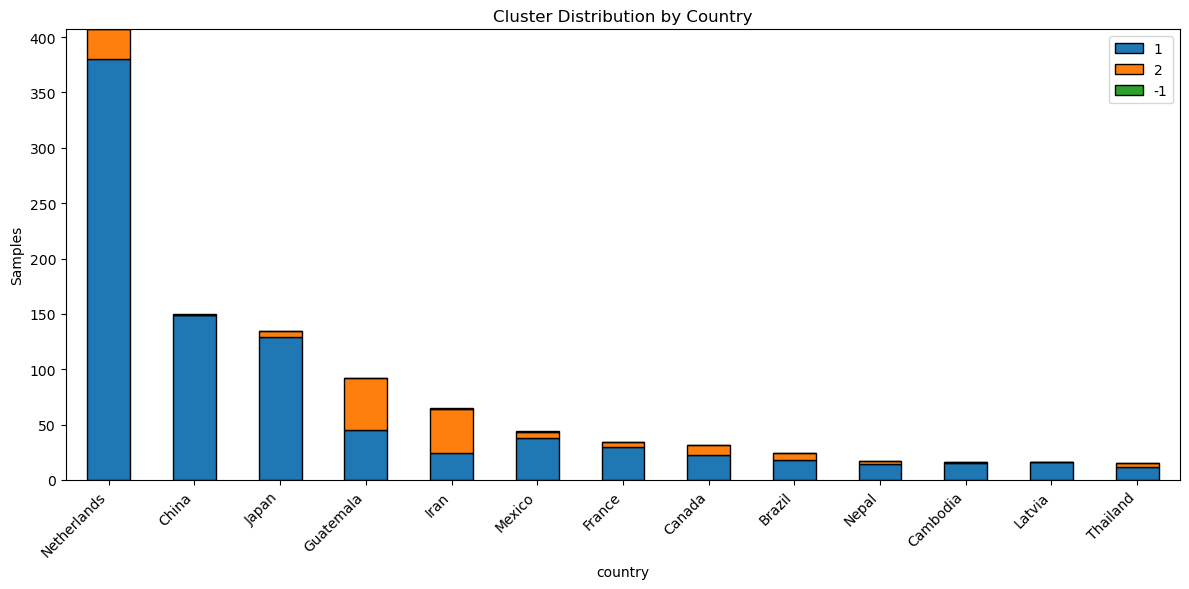

In [15]:
plot_df = pd.concat([df["country"], counts_df], axis=1)
plot_df = plot_df.set_index("country")
plot_df["total"] = plot_df.sum(axis=1)
plot_df = (
    plot_df
    .sort_values("total", ascending=False)
    .drop(columns="total")
)
plot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    edgecolor="black"
)
plt.ylabel("Samples")
plt.title("Cluster Distribution by Country")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

As can be seen in this plot, there are differences in the absolute count of samples, but at least visually also in the ratios of the previousy identified clusters

/opt/miniconda3/envs/L1-plotting/lib/python3.11/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
/opt/miniconda3/envs/L1-plotting/lib/python3.11/site-packages/sklearn/manifold/_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(


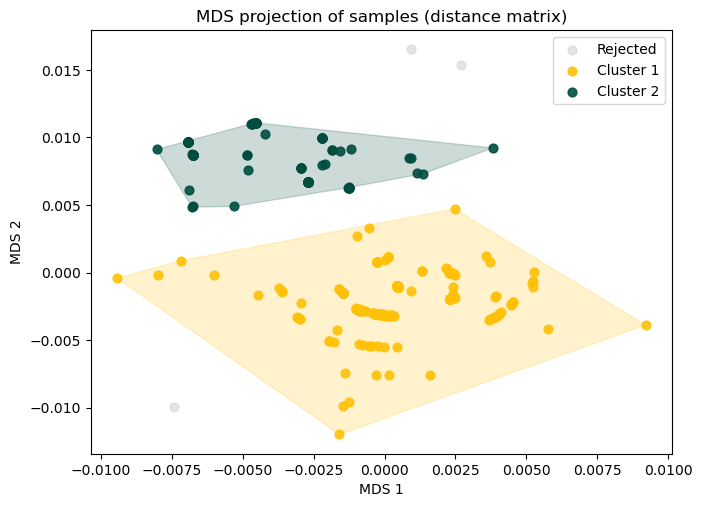

In [16]:
mds = MDS(
    n_components=2,
    dissimilarity="precomputed",
    random_state=111,
    n_init=4,
    max_iter=300
)

XY = mds.fit_transform( np.asarray(symm))

cluster_colors = {
    -1: "lightgrey",
     1: "#FFC107",
     2: "#004D40"
}

fig, ax = plt.subplots(figsize=(7.5, 5.5))

labels = np.unique(new_labels)

for lab in labels:
    pts = XY[new_labels == lab]

    color = cluster_colors.get(lab, "black") 
    
    if lab == -1:
        ax.scatter(
            pts[:, 0],
            pts[:, 1],
            s=40,
            alpha=0.6,
            color=color,
            label="Rejected"
        )
        continue
        
    ax.scatter(
        pts[:, 0],
        pts[:, 1],
        s=40,
        alpha=0.9,
        color=color,
        label=f"Cluster {lab}"
    )

    if len(pts) >= 3:
        hull = ConvexHull(pts)
        hull_pts = pts[hull.vertices]

        ax.fill(
            hull_pts[:, 0],
            hull_pts[:, 1],
            alpha=0.2,
            edgecolor="black",
            color=color,
            linewidth=1
        )

ax.set_xlabel("MDS 1")
ax.set_ylabel("MDS 2")
ax.set_title("MDS projection of samples (distance matrix)")
ax.legend()

As can be seen, the clusters appear well seperated

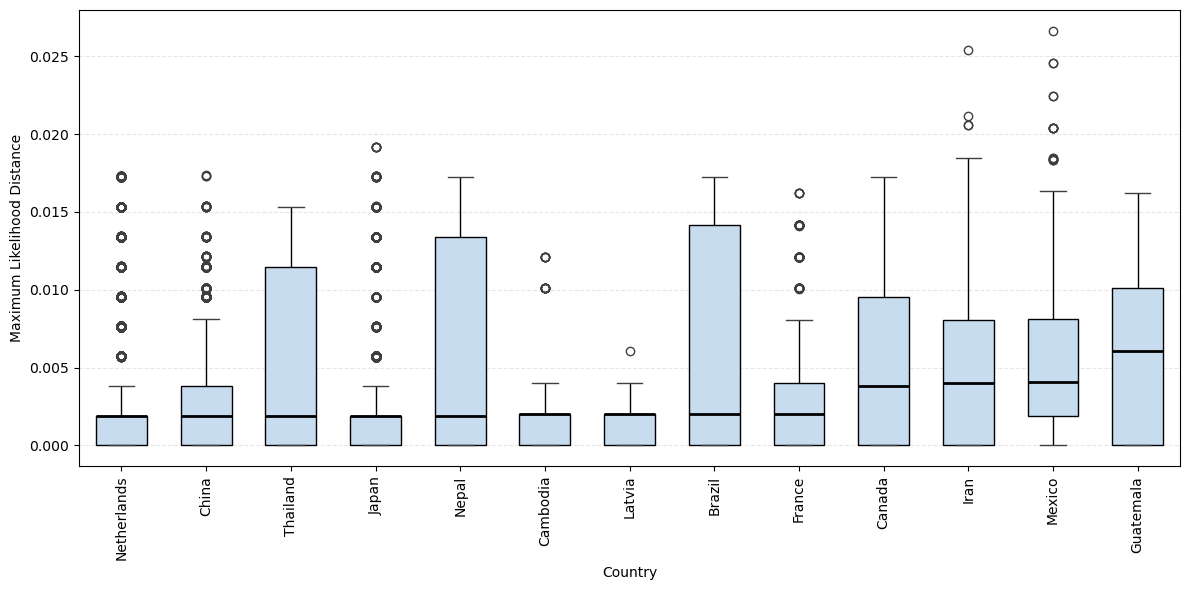

In [17]:
within = defaultdict(list)
between = defaultdict(list)

for i, j in combinations(symm.index, 2):
    d = symm.loc[i, j]
    if pd.isna(d): 
        continue
    c1, c2 = acc2country.get(i), acc2country.get(j)
    if c1 is None or c2 is None:
        continue
    if c1 == c2:
        within[c1].append(d)
    else:
        between[(c1,c2)].append(d)

within_dists = {}
for country in set(acc2country.values()):
    seqs = [acc for acc,c in acc2country.items() if c == country and acc in symm.index]
    if len(seqs) < 2:
        continue 
    vals = []
    for i,j in combinations(seqs, 2):
        vals.append(symm.loc[i,j])
    within_dists[country] = vals

wd_df = pd.DataFrame(
    [(c, v) for c, lst in within_dists.items() for v in lst],
    columns=["Country","Maximum Likelihood Distance"])

plt.figure(figsize=(12, 6))

order = (
    wd_df.groupby("Country")["Maximum Likelihood Distance"]
    .median()
    .sort_values()
    .index
)

sns.boxplot(
    data=wd_df,
    x="Country",
    y="Maximum Likelihood Distance",
    width=0.6,
    showcaps=True,
    boxprops={"facecolor": "#c7dcef", "edgecolor": "black"},
    medianprops={"color": "black", "linewidth": 2},
    whiskerprops={"color": "black"},
    showfliers=True,
    order = order
)

plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.gca().set_axisbelow(True)
plt.show()

As can be seen, there are differences in distribution and mean of within country ML distances

Here, log odds scores of cluster 1 and cluster 2 are computed for a test of how much cluster distance is explained by ratios of clusters per country.

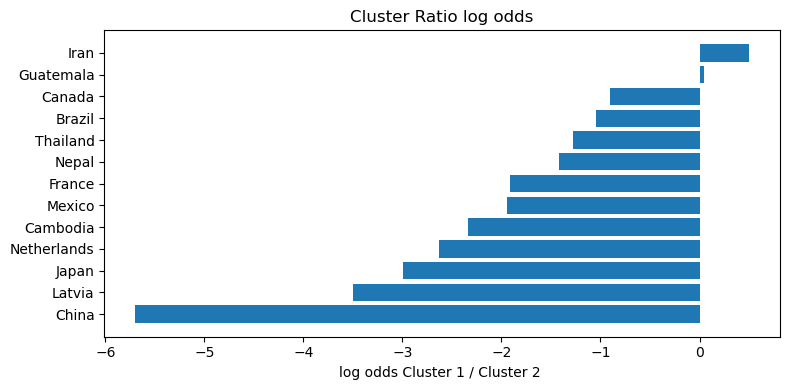

In [18]:
country2fraction1_2 = {}
for _, row in df.iterrows():
    country = row["country"]
    counts = row["counts"]
    if(-1 not in counts.keys()):
        counts[-1] = 0
    if(2 not in counts.keys()):
        counts[2] = 0
    country2fraction1_2[country] = np.log((counts[2]+0.5) / (counts[1] + 0.5))
    
df_bar = (
    pd.DataFrame.from_dict(country2fraction1_2, orient="index", columns=["ratio"])
      .sort_values("ratio")
)
plt.figure(figsize=(8, 4))
plt.barh(df_bar.index, df_bar["ratio"])
plt.xlabel("log odds Cluster 1 / Cluster 2 ")
plt.title("Cluster Ratio log odds")
plt.tight_layout()

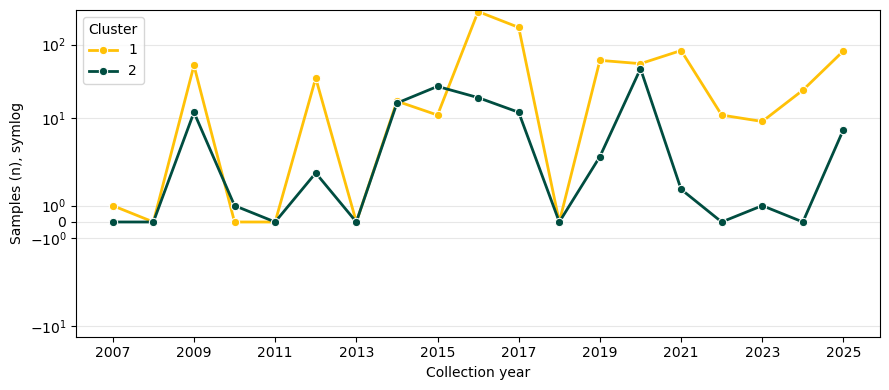

In [19]:
filtered.index = filtered["Accession"]
filtered["label"] = acc2label
filtered_label = filtered[~filtered["label"].isna()]
filtered_label["collection_year"] = pd.to_datetime(
    filtered_label["Release_Date"], errors="coerce"
).dt.year
df_time = filtered_label.dropna(subset=["collection_year", "label"])
df_time = df_time[df_time["label"] != -1]

freq = (df_time.groupby(["collection_year", "label"])
        .size()
        .reset_index(name="n"))

years = range(freq["collection_year"].min(), freq["collection_year"].max() + 1)
labels = sorted(freq["label"].unique())

full_idx = pd.MultiIndex.from_product([years, labels],
                                      names=["collection_year", "label"])

freq_full = (freq.set_index(["collection_year", "label"])
                .reindex(full_idx, fill_value=0)
                .reset_index())

plt.figure(figsize=(9, 4))
ax = sns.lineplot(
    data=freq_full.sort_values("collection_year"),
    x="collection_year", y="n",
    hue="label",
    palette=cluster_colors,
    marker="o", linewidth=2
)

ax.set(
    xlabel="Collection year",
    ylabel="Samples (n)",
    xticks=list(years)[::2],
)
ax.grid(True, axis="y", alpha=0.3)
ax.set_yscale("symlog", linthresh=5)
ax.set_ylabel("Samples (n), symlog")
ax.legend(title="Cluster", frameon=True)
plt.tight_layout()
plt.show()

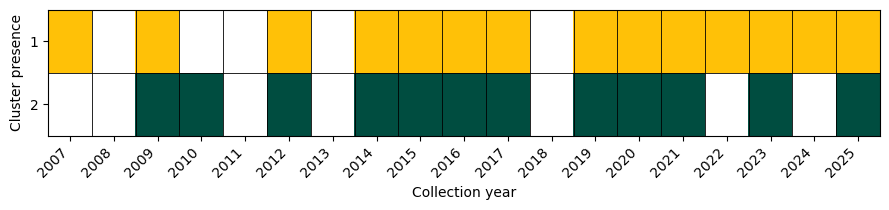

In [20]:
presence = (freq_full.assign(present=freq_full["n"] > 0) .pivot(index="label", columns="collection_year", values="present") .astype(int))
fig, ax = plt.subplots(figsize=(9, 2.2))

years = presence.columns
n_rows = len(presence)

for i, cluster in enumerate(presence.index):

    row = presence.loc[cluster].values.reshape(1, -1)

    cmap = ListedColormap(["white", cluster_colors.get(cluster, "grey")])
    
    ax.imshow(
        row,
        cmap=cmap,
        aspect="auto",
        interpolation="none",
        extent=[0, len(years), i, i + 1],
        vmin=0,
        vmax=1,
    )
    
ax.set_xticks(np.arange(len(years)), minor=True)
ax.set_yticks(np.arange(n_rows), minor=True)

ax.grid(which="minor", color="black", linestyle="-", linewidth=0.6)

ax.tick_params(which="minor", bottom=False, left=False)

ax.set_xlim(0, len(years))
ax.set_ylim(0, n_rows)

ax.set_xticks(np.arange(len(years)) + 0.5)
ax.set_xticklabels(years, rotation=45, ha="right")

ax.set_yticks(np.arange(n_rows) + 0.5)
ax.set_yticklabels(presence.index)

ax.set_xlabel("Collection year")
ax.set_ylabel("Cluster presence")

ax.invert_yaxis()
plt.tight_layout()
plt.show()

As can be seen, both labels are present over almost the whole timespan.

In [21]:
grouped = wd_df.groupby(by = "Country").mean()
grouped["logOdds"] = country2fraction1_2

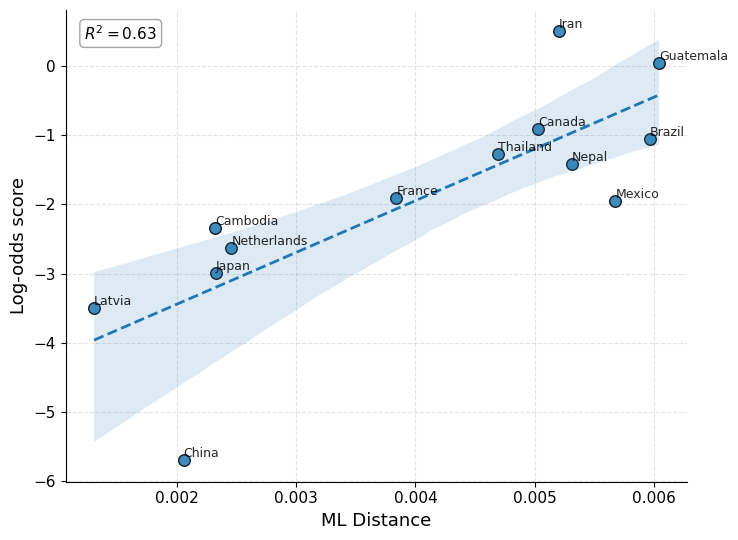

In [22]:
x = grouped["Maximum Likelihood Distance"].values
y = grouped["logOdds"].values

fig, ax = plt.subplots(figsize=(7.5, 5.5))

sns.regplot(
    x=x, y=y, ax=ax,
    ci=95, n_boot=2000,          # uncertainty band via bootstrap
    scatter_kws=dict(s=70, edgecolor="black", alpha=0.85),
    line_kws=dict(linestyle="--", linewidth=2)
)

# Labels
for country, row in grouped.iterrows():
    ax.text(row["Maximum Likelihood Distance"], row["logOdds"], country, fontsize=9, ha="left", va="bottom", alpha=0.85)

ax.set_xlabel("ML Distance", fontsize=13)
ax.set_ylabel("Log-odds score", fontsize=13)
ax.tick_params(labelsize=11)
ax.grid(True, linestyle="--", alpha=0.35)
ax.set_axisbelow(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# R²
coef = np.polyfit(x, y, 1)
r2 = r2_score(y, coef[0]*x + coef[1])
ax.text(
    0.03, 0.97, f"$R^2 = {r2:.2f}$",
    transform=ax.transAxes, ha="left", va="top", fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.6", alpha=0.9)
)

plt.tight_layout()
plt.show()

As can be seen in this scatterplot, a reasonable amount of the Mean Distance per country can be explained by the log odds score, with china being a clear outlier, due to having no amount of cluster 2 at all, which is likely a sampling artefact.

In [23]:
grouped["coverage_2018"] = country2coverage
grouped_filtered = grouped.dropna()
grouped["gni"] = mean_gni[mean_gni.index.isin(grouped.index)]

x = grouped_filtered["logOdds"].values
y = grouped_filtered["coverage_2018"].values
coef = np.polyfit(x, y, 1)    
r2_coverage = r2_score(y, coef[0] * x + coef[1])
x = grouped["logOdds"].values
y = np.log(grouped["gni"].values)
coef = np.polyfit(x, y, 1)
r2_gni = r2_score(y, coef[0] * x + coef[1])

print(f"correlation coefficient of log odds score with vaccine coverage 2018: {r2_coverage} \ncorrelation coefficient of log odds score with mean GNI: {r2_gni}")

correlation coefficient of log odds score with vaccine coverage 2018: 0.13304338204997523 
correlation coefficient of log odds score with mean GNI: 0.06548687308841916


As can be seen, unfortunately neither vaccine coverage or GNI seem to explain the variance of the cluster ratios, leading to the conclusion that the ratios are likely either epidemiologic spread artefacts, adaptations to environments or population structures, functional adaptations/ tradeoffs or just random genetic drift, due to which we unfortunately have to reject the hypothesis that these factors are showing up in a cleanly measureable way in L1 sequence variability.